In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re


## raw data

In [2]:
ds_df = pd.read_csv('data_science_job.csv', encoding='latin1')
post_df = pd.read_csv('job_postings.csv')
skil_df = pd.read_csv('job_skills.csv')

In [3]:
ds_df.head(1)

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"


In [4]:
post_df.head(1)

,job_link,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/senior-mach...,2024-01-21 08:08:48.031964+00,Finished NER,t,t,f,Senior Machine Learning Engineer,Jobs for Humanity,"New Haven, CT",2024-01-14,East Haven,United States,Agricultural-Research Engineer,Mid senior,Onsite


In [5]:
skil_df.head(1)

,job_link,job_skills
0,https://www.linkedin.com/jobs/view/senior-mach...,"Machine Learning, Programming, Python, Scala, ..."


In [6]:
drop_columns = ['last_processed_time', 'last_status', 'got_summary', 'got_ner', 'is_being_worked', 'job_location', 'search_city', 'search_country', 'job_type', 'search_position']
country_mask = post_df['search_country'] == 'United States'
link_df = post_df[country_mask].drop(columns=drop_columns).drop_duplicates().merge(skil_df, how='outer', on='job_link')
link_df.rename(columns={
  'job_link': 'link',
  'job_title': 'title',
  'first_seen': 'date',
  'job_level': 'level',
  'job_skills': 'skills',
  }, inplace=True)
print(link_df.shape)
print('levels', link_df['level'].unique())
link_df.loc[link_df['level'] == 'Mid senior', 'level'] = 'senior'
link_df.loc[link_df['level'] == 'Associate', 'level'] = 'junior'
link_df.head(3)

(12217, 6)
levels ['Mid senior' 'Associate' nan]


,link,title,company,date,level,skills
0,https://www.linkedin.com/jobs/view/senior-mach...,Senior Machine Learning Engineer,Jobs for Humanity,2024-01-14,senior,"Machine Learning, Programming, Python, Scala, ..."
1,https://www.linkedin.com/jobs/view/principal-s...,"Principal Software Engineer, ML Accelerators",Aurora,2024-01-14,senior,"C++, Python, PyTorch, TensorFlow, MXNet, CUDA,..."
2,https://www.linkedin.com/jobs/view/senior-etl-...,Senior ETL Data Warehouse Specialist,Adame Services LLC,2024-01-14,junior,"ETL, Data Integration, Data Transformation, Da..."


In [7]:
country_mask = ds_df['Location'].isna() | ds_df['Location'].str.contains('United States')
ds_s_df = ds_df[country_mask].drop(columns=['Job Type', 'Location', 'Facilities']).drop_duplicates()
ds_s_df.rename(columns={
  'Company': 'company', 
  'Job Title': 'title', 
  'Experience level': 'level',
  'Salary': 'salary',
  'Requirment of the company ': 'skills'
  }, inplace=True)
print(ds_s_df.shape)
print('levels', ds_s_df['level'].unique())
ds_s_df.loc[ds_s_df['level'] == 'Entry-level', 'level'] = 'junior'
ds_s_df.loc[ds_s_df['level'] == 'Mid-level', 'level'] = 'middle'
ds_s_df.loc[ds_s_df['level'] == 'Senior-level', 'level'] = 'senior'
ds_s_df.loc[ds_s_df['level'] == 'Executive-level', 'level'] = 'executive'
ds_s_df.head(3)

(575, 5)
levels ['Entry-level' nan 'Mid-level' 'Senior-level' 'Executive-level']


,company,title,level,salary,skills
0,SGS,Clinical Data Analyst,junior,48K+ *,"Computer Science,Data quality,Genetics,Mathema..."
2,Cricut,Machine Learning Engineer,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput..."
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,middle,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow..."


## merged df

In [8]:
main_df = pd.concat([ds_s_df, link_df], join='outer', ignore_index=True)
main_df['company'] = main_df['company'].str.lower()
main_df['title'] = main_df['title'].str.lower()
main_df['skills'] = main_df['skills'].str.lower()
main_df.drop(columns=['level', 'link', 'date'], inplace=True)
main_df.sample(5, random_state=10)

,company,title,salary,skills
2460,eurofins pss insourcing solutions,senior data analyst and reporting specialist,NaN,"data processing, statistical analysis, report ..."
7912,michael page,superintendent - data center construction - na...,NaN,"field expertise, groundup construction, team l..."
928,skf group,senior mdm global data specialist americas,NaN,"sap mdg, s4 hanna, sap business client, servic..."
8013,walmart,"(usa) staff, data engineer",NaN,"data architecture, distributed computing, apac..."
7793,jobs for humanity,"senior manager, ontology and data modeling",NaN,"ontology development, data modeling, semantic ..."


In [9]:
# salary transformation
salary_mask = main_df['salary'].notna()
k_m_to_zeros = lambda x: re.sub(r'[^\dKM]', '', x).replace('K', '000').replace('M', '000000') if type(x) == str else x

main_df.loc[salary_mask, 'salary'] = main_df.loc[salary_mask, 'salary'].apply(k_m_to_zeros)
main_df.loc[salary_mask, 'salary'] = main_df.loc[salary_mask, 'salary'].astype(int)

# date transformation
# date_mask = main_df['date'].notna()
# main_df.loc[date_mask, 'date'] = pd.to_datetime(main_df.loc[date_mask, 'date'])

# min_date = main_df.loc[date_mask, 'date'].min()
# max_date = main_df.loc[date_mask, 'date'].max()
# full_date_range = pd.date_range(start=min_date, end=max_date)
# print(full_date_range.difference(main_df.loc[date_mask, 'date'].unique()))

main_df[salary_mask].sample(5, random_state=42)

,company,title,salary,skills
521,palo alto networks,attack surface data analyst (xpanse),74000,"engineering,excel,mathematics,research,securit..."
79,housecall pro,data analyst i - fraud,72000,"economics,engineering,fintech,looker,mathemati..."
374,dentsu international,data engineer,78000,"architecture,azure,bigquery,computer science,d..."
92,block,business intelligence engineering manager,172000,"banking,blockchain,business intelligence,compu..."
491,lightning ai,staff developer advocate - ai & machine learning,127000,"computer vision,content creation,engineering,m..."


## Summary

In [161]:
def get_skill_counts(df):
  split_skills = lambda x: [re.sub(r'[^\w\s]','', y.strip()) for y in x.strip().split(',')]
  skills_2d = df.loc[df['skills'].notna(), 'skills'].str.lower().apply(split_skills)
  skills_flat = np.array(list(filter(lambda x:x, [y for x in skills_2d for y in x])))
  return pd.Series(data=skills_flat).value_counts()

def trim_labels(labels, size=20):
  return [l[:max(size-3, 0)] +'...' if len(l) > size else l for l in labels]

def largest_diff_idx(nums: np.ndarray):
  diffs = nums[:-1]-nums[1:]
  return np.argmax(diffs) + 1


In [47]:
# masks
ds_mask = main_df['title'].str.contains('data') & main_df['title'].str.contains('scien') 
ml_mask = (main_df['title'].str.contains('machine') & main_df['title'].str.contains('learning')) | main_df['title'].str.contains('ml')  

## Total


In [48]:
print(main_df.shape)
main_df.sample(3, random_state=42)

(12792, 4)


,company,title,salary,skills
4091,nvidia,senior datacenter product development engineer...,NaN,"datacenter ai compute system development, new ..."
3921,dice,sr. data analyst (no c2c),NaN,"data analysis, advanced ms excel, sql, powerbi..."
1355,jobs for humanity,senior data engineer,NaN,"java, scala, python, rdbms, nosql, redshift, s..."


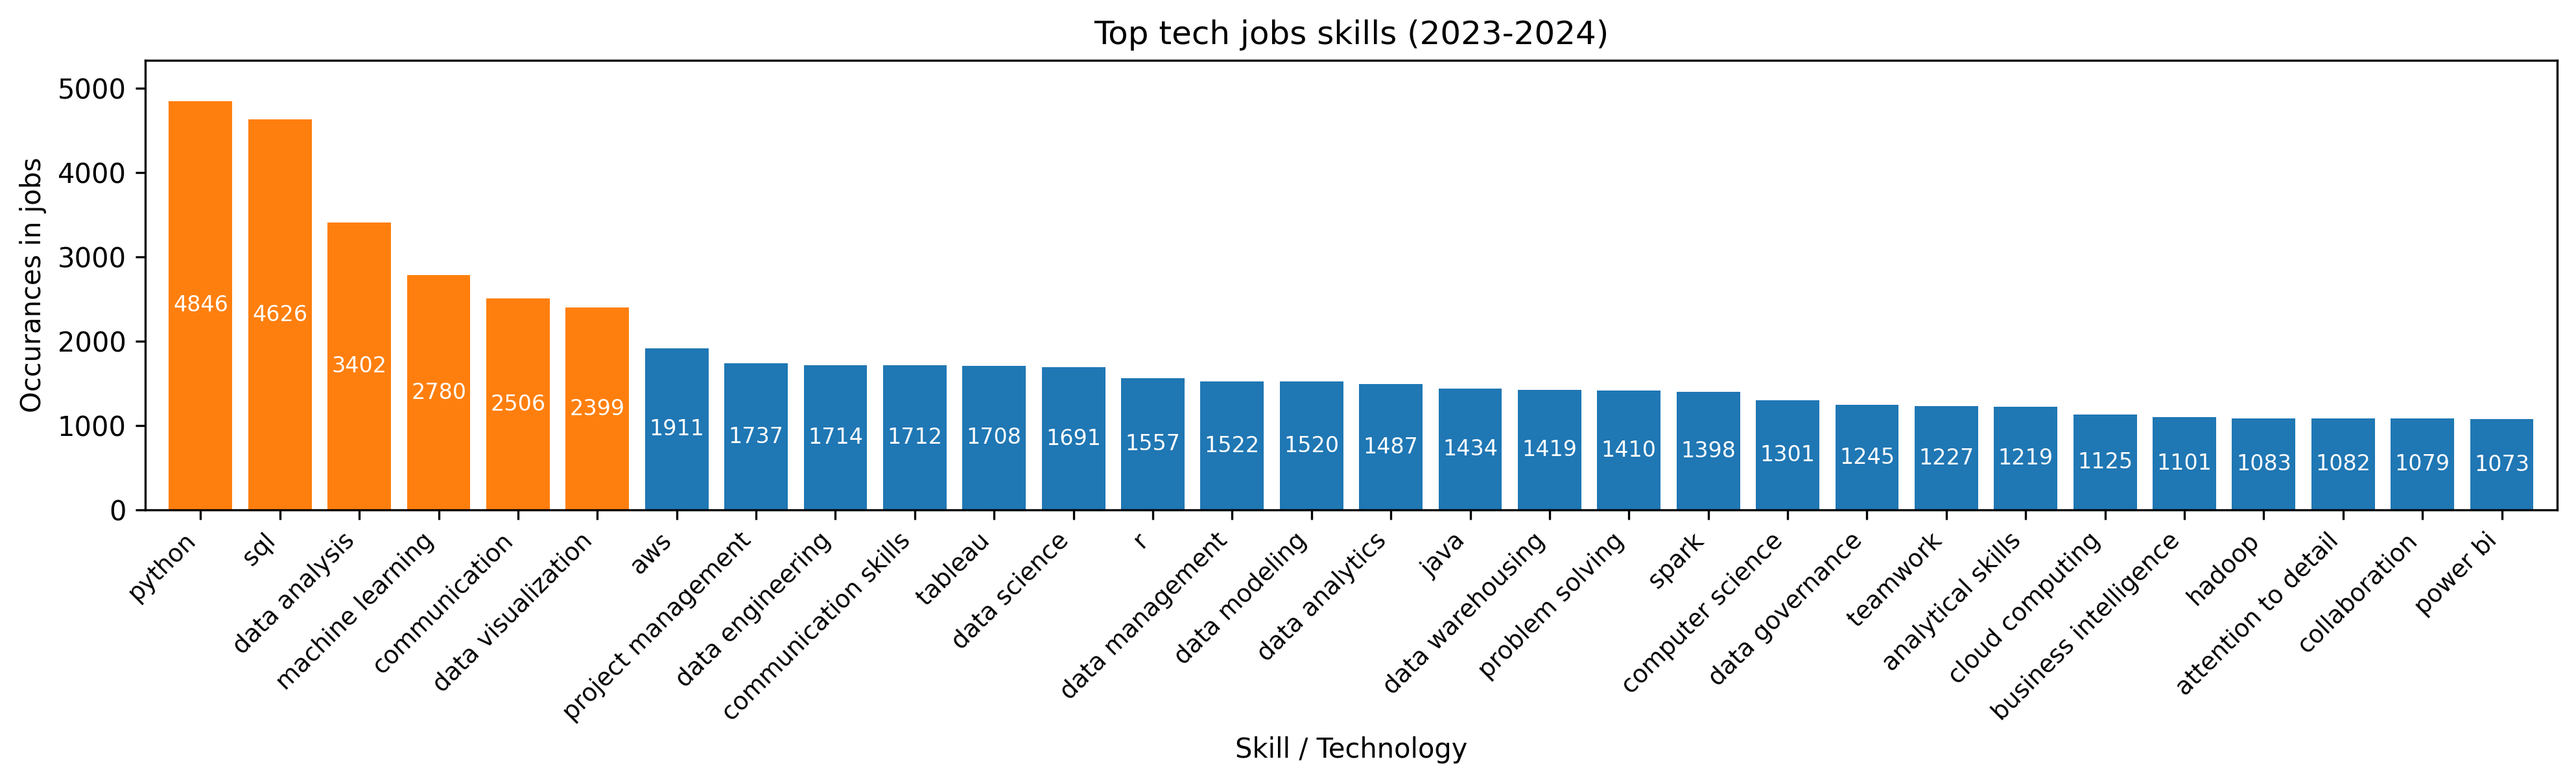

In [107]:
# plot
total_skill_counts = get_skill_counts(main_df)[:30]
plt.figure(figsize=(16,3), dpi=300)
plt.margins(x=0.01, y=0.1)
xs, heights = total_skill_counts.index, total_skill_counts.values
bar_colors = ['tab:orange' if x > 2000 else 'tab:blue' for x in heights] 
total_barplot = plt.bar(x=xs, height=heights, color=bar_colors)
plt.title('Top tech jobs skills (2023-2024)')
plt.xlabel('Skill / Technology')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=9)
plt.bar_label(container = total_barplot, label_type = "center", fontsize=8, color="white")
plt.ylabel('Occurances in jobs')
plt.show()


## Data Science


In [14]:
print(main_df[ds_mask].shape)
main_df[ds_mask].sample(3, random_state=42)

(1022, 4)


,company,title,salary,skills
10600,rwe,energy trading data scientist m/f/t,NaN,"python, r, sql, tableau, data visualization, d..."
5110,"scaled agile, inc.",senior data scientist,NaN,"python, pandas, numpy, scikitlearn, statistics..."
7996,figma,"data scientist, product",NaN,"data science, machine learning, statistical mo..."


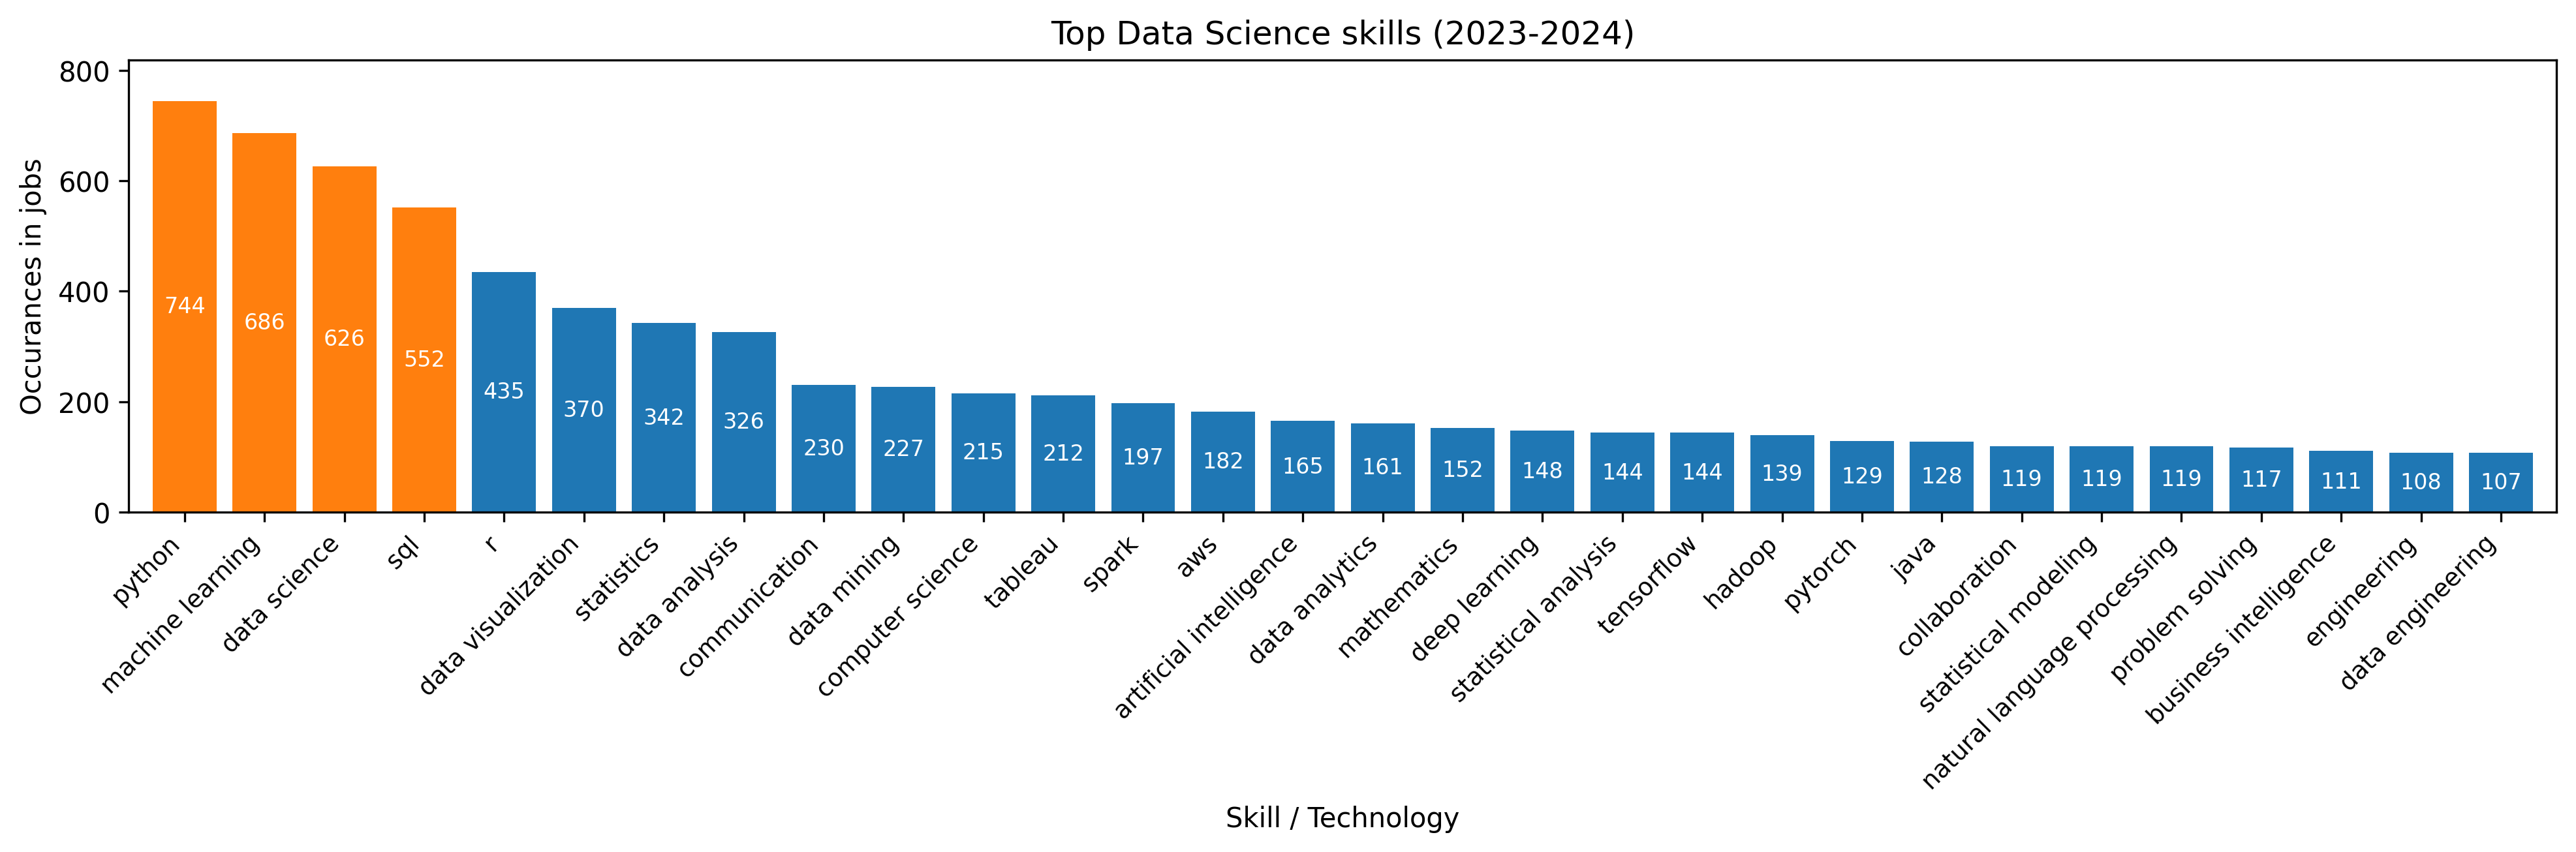

In [171]:
# DS plot
ds_skill_counts = get_skill_counts(main_df[ds_mask])[:30]
plt.figure(figsize=(16,3), dpi=300)
plt.margins(x=0.01, y=0.1)
xs, heights = ds_skill_counts.index, ds_skill_counts.values
diff_idx = largest_diff_idx(heights)
bar_colors = ['tab:orange'] * diff_idx + ['tab:blue'] * (len(heights) - diff_idx)
total_barplot = plt.bar(x=xs, height=heights, color=bar_colors)
plt.title('Top Data Science skills (2023-2024)')
plt.xlabel('Skill / Technology')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=9)
plt.bar_label(container = total_barplot, label_type = "center", fontsize=8, color="white")
plt.ylabel('Occurances in jobs')
plt.show()



## Machine Learning


In [100]:
print(main_df[ml_mask].shape)
main_df[ml_mask].sample(3, random_state=42)

(1964, 4)


,company,title,salary,skills
5037,genentech,"machine learning engineer, prescient design",NaN,"machine learning, data sources, software desig..."
6313,labcorp,phlebotomist part time - paml,NaN,"phlebotomy, blood collection, data entry, bill..."
307,playstation global,machine learning engineer (master's/phd),127000,"deep learning,engineering,machine learning,num..."


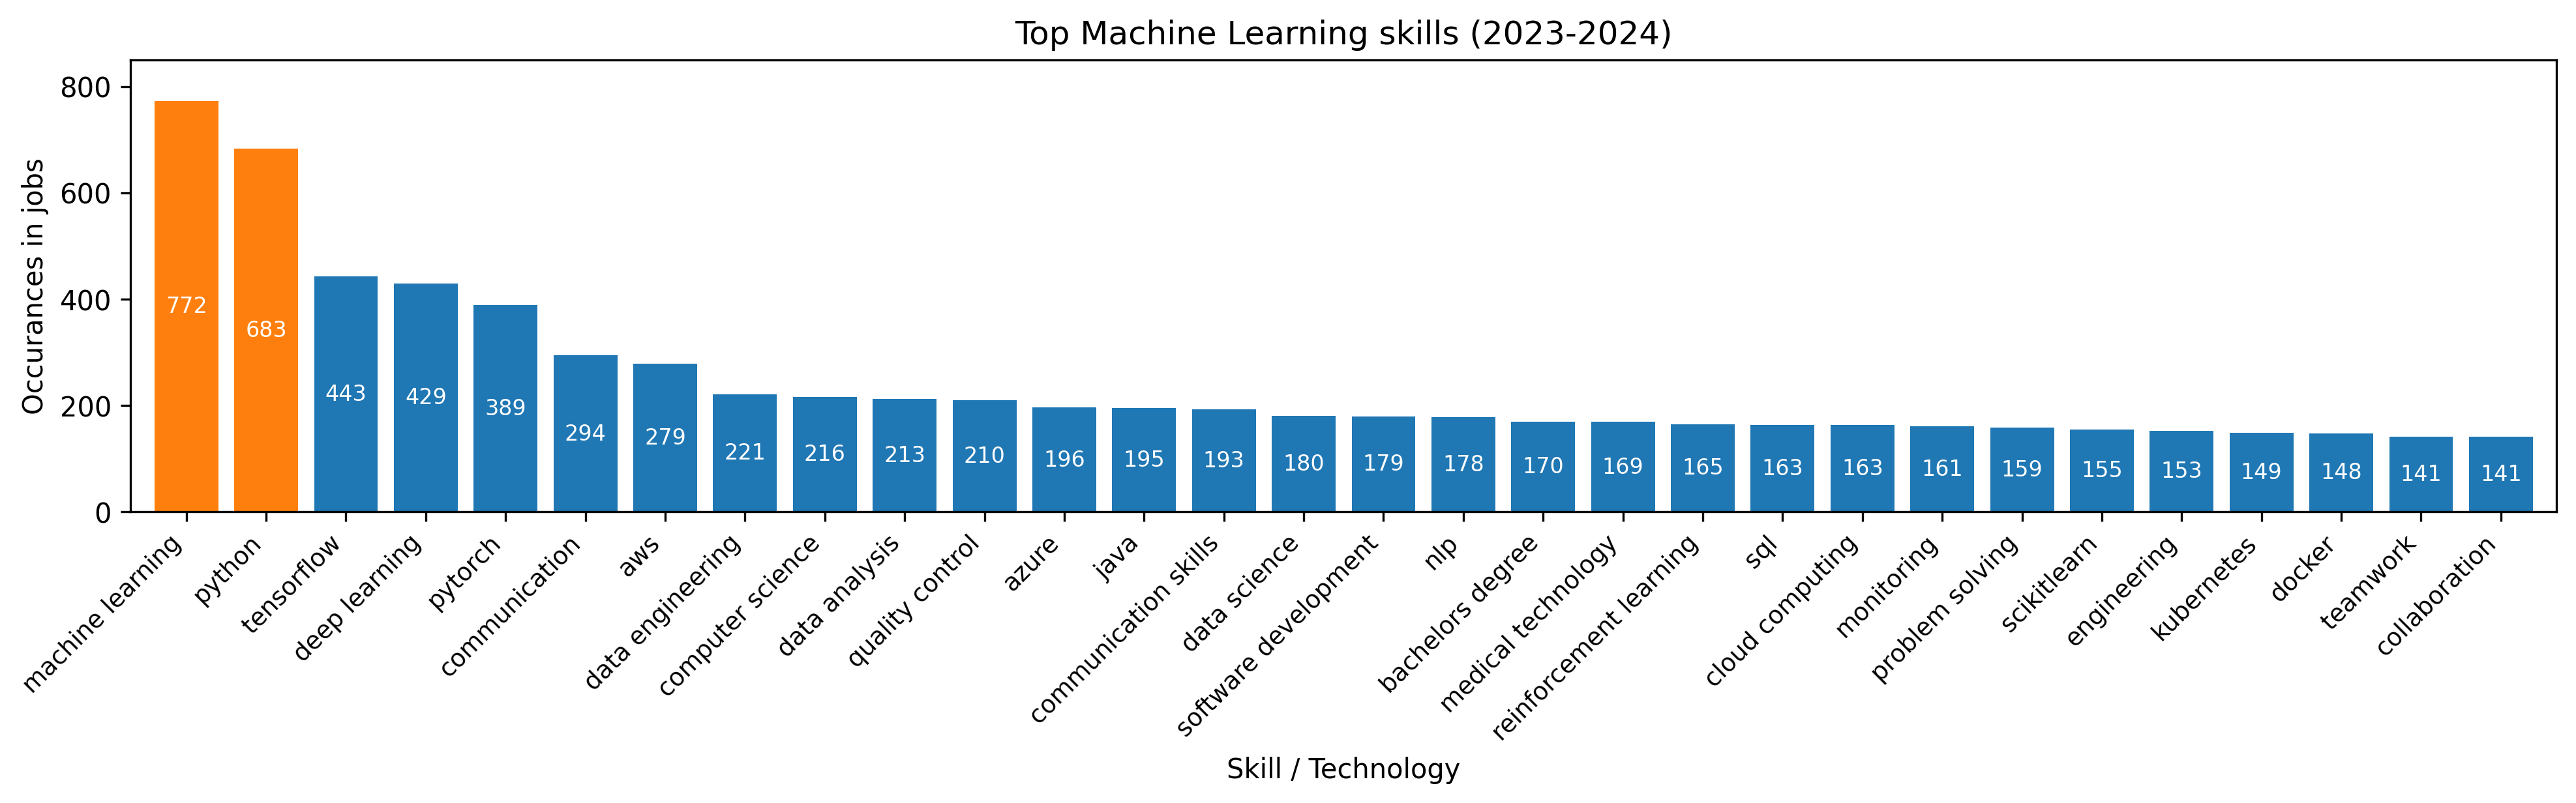

In [170]:
# ML plot
ds_skill_counts = get_skill_counts(main_df[ml_mask])[:30]
plt.figure(figsize=(16,3), dpi=300)
plt.margins(x=0.01, y=0.1)
xs, heights = ds_skill_counts.index, ds_skill_counts.values
diff_idx = largest_diff_idx(heights)
bar_colors = ['tab:orange'] * diff_idx + ['tab:blue'] * (len(heights) - diff_idx)
total_barplot = plt.bar(x=xs, height=heights, color=bar_colors)
plt.title('Top Machine Learning skills (2023-2024)')
plt.xlabel('Skill / Technology')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=9)
plt.bar_label(container = total_barplot, label_type = "center", fontsize=8, color="white")
plt.ylabel('Occurances in jobs')
plt.show()


## companies with lots of entry-level jobs


In [177]:
title_mask = main_df['title'].notna()
main_df.loc[title_mask & main_df['title'].str.contains(r'manager'), 'level'] = 'manager'
main_df.loc[title_mask & main_df['title'].str.contains(r'mid|middle|associate'), 'level'] = 'middle'
main_df.loc[title_mask & main_df['title'].str.contains(r'senior|sr|lead'), 'level'] = 'senior'
main_df.loc[title_mask & main_df['title'].str.contains(r'staff|executive|principal|distinguished|director'), 'level'] = 'staff+'
main_df.loc[main_df['level'].isna(), 'level'] = 'junior'

job_level_counts = main_df[main_df['level']=='junior'].drop_duplicates().groupby('company').size().sort_values(ascending=False)[:30]


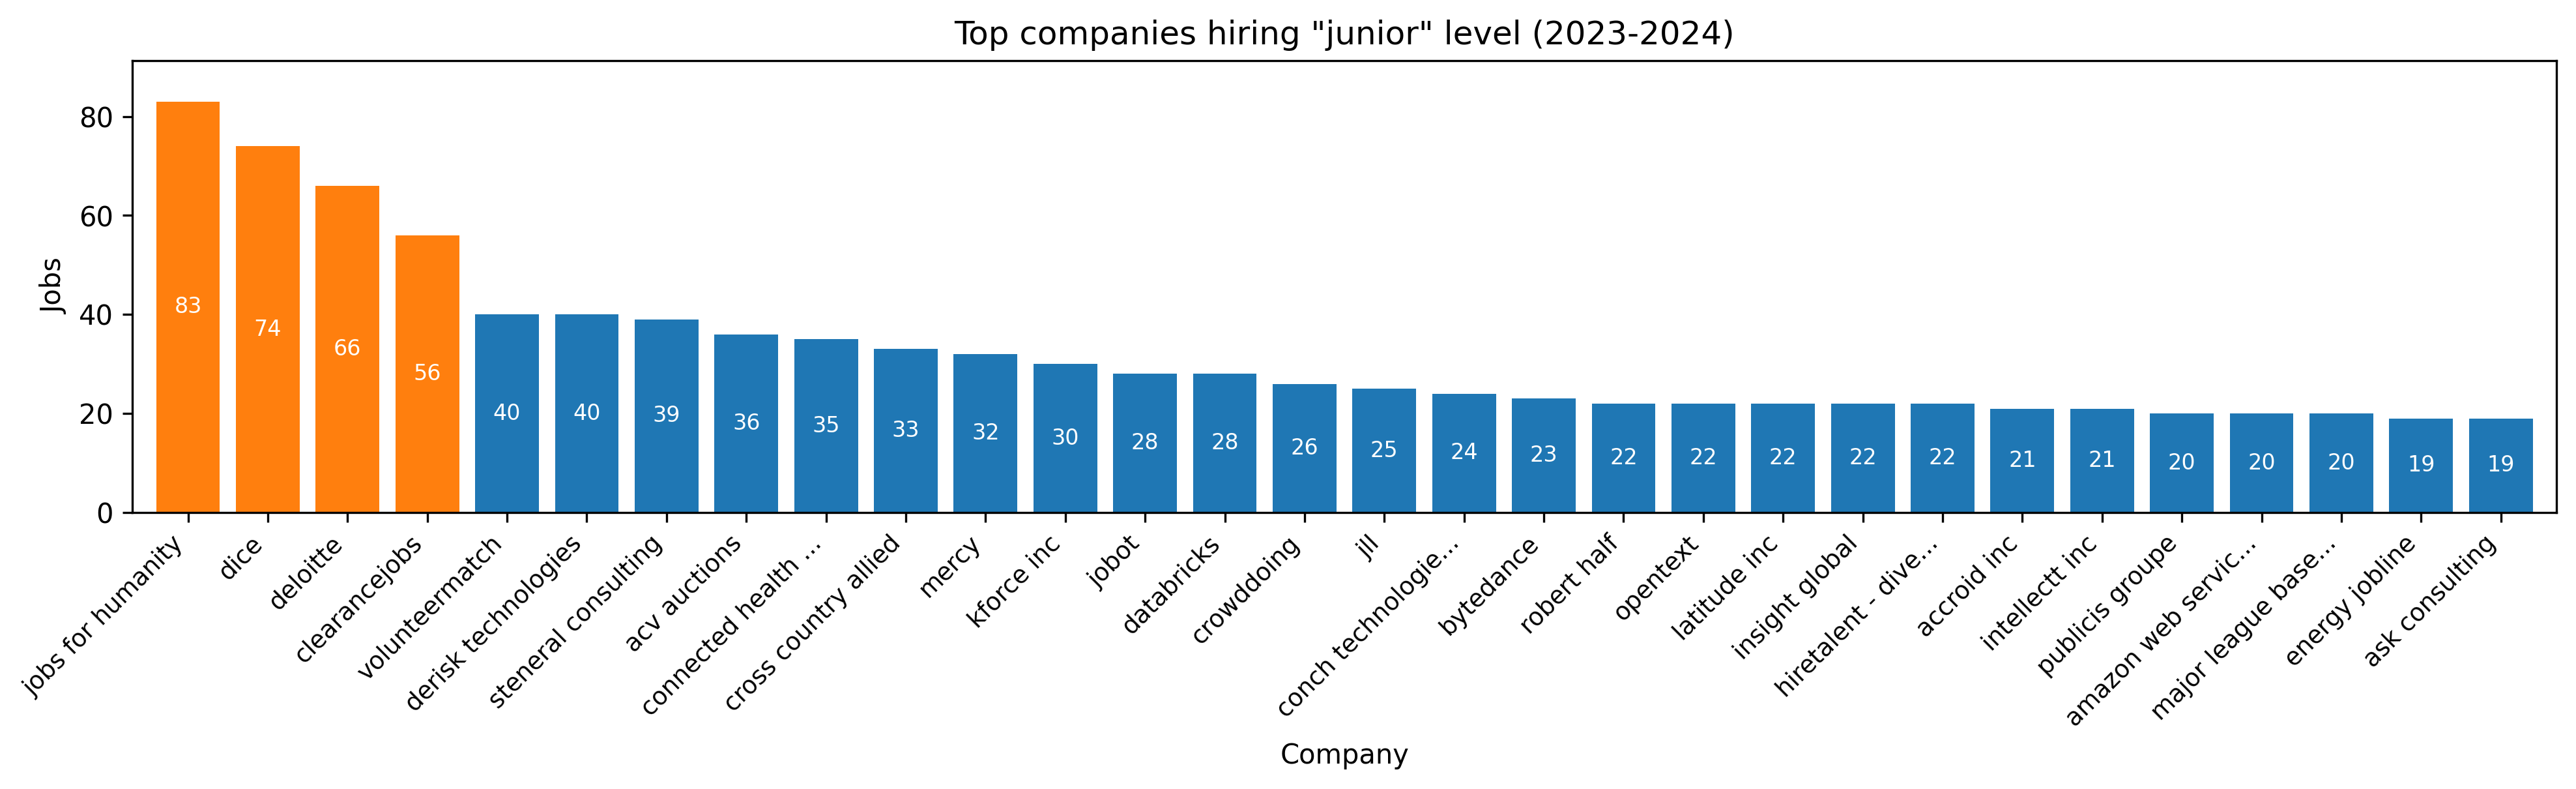

In [178]:
plt.figure(figsize=(16,3), dpi=300)
plt.margins(x=0.01, y=0.1)
xs, heights = trim_labels(job_level_counts.index), job_level_counts.values
diff_idx = largest_diff_idx(heights)
bar_colors = ['tab:orange'] * diff_idx + ['tab:blue'] * (len(heights) - diff_idx)
total_barplot = plt.bar(x=xs, height=heights, color=bar_colors)
plt.title('Top companies hiring "junior" level (2023-2024)')
plt.xlabel('Company')
plt.xticks(rotation=45, horizontalalignment='right', fontsize=9)
plt.bar_label(container = total_barplot, label_type = "center", fontsize=8, color="white")
plt.ylabel('Jobs')
plt.show()
